# Introdução
---
O ano é 2021. 

O mundo atravessa uma pandemia digna de filmes de ação, terror, ficção científica, etc.

No final de 2019, na China, mais especificamente em Wuhan, foram descobertas as primeiras infeccçoes causadades pelo SARS-CoV-2, um vírus respiratório que, até o momento causou 2.7 milhões de mortes pelo mundo.

No Brasil, o cenário não é muito diferente.
Hoje (22/03/2021), com mais de 292 mil óbitos confirmados, o Brasil ocupa o segundo lugar no ranking de países que mais perderam vidas para a COVID-19.

Atualmente, estamos beirando o colapso do sistema de saúde e acumulando mortes de pessoas que estavam aguardando por um leito de UTI.

Tendo este cenário em mente, o hospital Sírio Libanês publicou no Kaggle (https://www.kaggle.com/Sírio-Libanes/covid19) um desafio com o objetivo de tentar identificar com base em uma série de indicadores da saúde do paciente, o mais rápido possível, se um paciente precisará de um leito de UTI ou não.

A base de dados disponibilizada conta com dados relativos a:
- Informações demográficas
- Doenças prévias
- Resultados de exames de sangue
- Sinais vitais

Para mais informações, acesse o site supra citado.

---

# Objetivo
---
- Conseguir prever, baseado em indicadores de saúde, se, logo nas primeiras horas, um paciente precisará de um leito de UTI ou não.

---

# Análise Exploratória


## Bibliotecas

In [ ]:
!pip install pyforest
!pip install lazypredict
!pip install tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tqdm.notebook as tq

from tqdm import tqdm
from tqdm import trange


import pyforest
import lazypredict
from lazypredict.Supervised import LazyClassifier

from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

## Definição de funções

In [ ]:
# Definiciao de Seed para as tratativas aleatorias dos algoritmos de ML
np.random.seed(5488217)

<IPython.core.display.Javascript object>

In [ ]:
# Funcao que remove os paciente que foram internados na primeira janela
def remove_UTI_primeria_janela (dados):
  print ("=== Dados Brutos ===")
  print (f"Numero de Linhas: {dados.shape[0]}")
  print (f"Numero de Pacientes Unicos: {dados['PATIENT_VISIT_IDENTIFIER'].nunique()}")
  pacientes_remover = dados.query('WINDOW=="0-2" and ICU=="1"')['PATIENT_VISIT_IDENTIFIER'].values
  dados_tratados = dados.query('PATIENT_VISIT_IDENTIFIER not in @pacientes_remover')
  print ("=== Dados apos remocao dos pacientes que foram internado na UTI logo na primeira janela ===")
  print (f"Numero de Linhas: {dados_tratados.shape[0]}")
  print (f"Numero de Pacientes Unicos: {dados_tratados['PATIENT_VISIT_IDENTIFIER'].nunique()}")  
  return dados_tratados

In [ ]:
# Funcao que preenche dados faltantes baseado nos valores das linhas posteriores e anteriores.
# O range [:,13:-2] se refere a todos os dados continuos da base de dados. 
# Os dados [:,:13] e [:,-2:-1] se referem aos dados categoricos
# [:,-1:] e a coluna com a saida de dados

def preenche_dados_faltantes(dados):
  print(f"Numero de colunas: {len(dados.columns)}")
  print(f"Numero de colunas com campos nulos: {np.sum(dados.isnull().sum()>0)}")
  features_continuas_colunas = dados.iloc[:,13:-2].columns
  features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
  features_categoricas = dados.iloc[:,:13]
  saida = dados.iloc[:, -2:]
  dados_tratados = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis = 1)
  dados_tratados.columns = dados.columns

  dados_tratados = dados_tratados.dropna()

  print(f"Numero de colunas com campos nulos apos tratamento dos dados: {np.sum(dados_tratados.isnull().sum()>0)}")
  return dados_tratados

In [ ]:
# Funcao a ser utilizada na funcao apply para agrupar dados dos pacientes
# Esta funcao verifica os registros nos quais o paciente foi para a UTI em qualquer janela de tempo
# Caso ele tenha sido internado, o registro da primeira janela de tempo é marcado como True para o campo 'ICU'.
# Caso contrario, a primeira janela de tempo é retornada.

def agrupar_ICU(rows):
  if(np.any(rows['ICU'])):
    rows.loc[rows['WINDOW']=='0-2','ICU'] = 1
  return rows.loc[rows['WINDOW']=='0-2']

In [ ]:
def tratar_dados_categoricos(dados):
  age = {
    '10th': 10,
    '20th': 20,
    '30th': 30,
    '40th': 40,
    '50th': 50,
    '60th': 60,
    '70th': 70,
    '80th': 80,
    '90th': 90,
    'Above 90th':100
  }

  dados['AGE_PERCENTIL'] = dados['AGE_PERCENTIL'].map(age)
  dados.drop('WINDOW', axis=1, inplace=True)
  return dados

In [ ]:
# Funçao disponibilizada pelos autores do desafio considerando as features de maior relevancia

def makebio_df(df):

  df["BLOODPRESSURE_ARTERIAL_MEAN"] = (df['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
  df["NEUTROPHILES/LINFOCITOS"] = df['NEUTROPHILES_MEAN']/df['LINFOCITOS_MEAN']
  df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
  df["GASO"] = (~df["GASO"].isna()).astype(int)
  return df[["ICU",
               "AGE_ABOVE65", 
               "GENDER", 
               "BLOODPRESSURE_ARTERIAL_MEAN", 
               "RESPIRATORY_RATE_MAX", 
               "HTN", 
               "DISEASE GROUPING 1",
               "DISEASE GROUPING 2",
               "DISEASE GROUPING 3",
               "DISEASE GROUPING 4",
               "DISEASE GROUPING 5",
               "DISEASE GROUPING 6",
               "NEUTROPHILES/LINFOCITOS",
               "GASO",
               "OXYGEN_SATURATION_MIN",
               "HEART_RATE_MAX",
               "PCR_MEAN",
               "CREATININ_MEAN"]]

---
Os dados que serão utilizados neste trabalho foram obtidos através do link https://www.kaggle.com/Sírio-Libanes/covid19/download em 16/03/2021

---

## Tratamento dos dados

In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(url)
dados

<IPython.core.display.Javascript object>

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

---
As 1925 linhas são relativas aos vários indicadores que foram gerados durante o tempo de permanência do paciente no hospital até que ele fosse encaminhado à UTI ou não.

Estas 1925 linhas estão relacionadas a 385 pacientes diferentes.

---

---
De acordo com a proposição do problema, os dados da janela em que o usuário foi internado na UTI não devem ser utilizados. Sendo assim, os pacientes que foram internados logo na primeira janela serão removidos do conjuntos de dados a ser trabalhado, restando 353 pacientes únicos.

---

In [ ]:
dados_sem_UTI_primeira_janela = remove_UTI_primeria_janela(dados)

=== Dados Brutos ===
Numero de Linhas: 1925
Numero de Pacientes Unicos: 385
=== Dados apos remocao dos pacientes que foram internado na UTI logo na primeira janela ===
Numero de Linhas: 1765
Numero de Pacientes Unicos: 353


---
O conjunto dos dados é composto por 231 colunas, nas quais 225 possuem campos não preenchidos. Estes campos serão preenchidos utilizando os dados do pacientes disponíveis nas janelas anteriores ou posteriores.

Esta estratégia foi recomendada pelo time do Sirio Libanês, como pode ser visto em https://www.kaggle.com/Sírio-Libanes/covid19 na seção Tips & Tricks - Missing Data

---

In [ ]:
dados_preenchidos = preenche_dados_faltantes(dados_sem_UTI_primeira_janela)

Numero de colunas: 231


<IPython.core.display.Javascript object>

Numero de colunas com campos nulos: 225


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numero de colunas com campos nulos apos tratamento dos dados: 0


---
Um dos componentes do problema é a identificação da necessidade de UTI o mais breve possível, como indicado em https://www.kaggle.com/Sírio-Libanes/covid19 na seção Tips & Tricks - The earlier, the better!).

Sendo assim, os dados utilizarão somente os registros da primeira janela de tempo disponível.
Os pacientes que foram internados em qualquer janela de tempo serão alterados e o campo 'ICU' conterá a informação de internação.

---

In [ ]:
dados_limpos = dados_preenchidos.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).apply(agrupar_ICU)
print(f"Numero de Linhas: {dados_limpos.shape[0]}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numero de Linhas: 352


---
Os campos categóricos não numéricos precisaram ser tratados neste momento.

- O campo AGE_PERCENTIL foi alterado para que seja um campo numérico.
- O campo WINDOW foi removido, pois somente a janela 0-2 é utilizada neste momento.
---

In [ ]:
dados_tratados = tratar_dados_categoricos(dados_limpos)

---
Uma função que indica as features mais relevantes, do ponto de vista dos autores do desafio, foi disponibilizada.

Será criado um novo conjunto de dados considerando somente estas features.

---

In [ ]:
dados_tratados_features = makebio_df(dados_tratados)
dados_tratados_features.head()

,,ICU,AGE_ABOVE65,GENDER,BLOODPRESSURE_ARTERIAL_MEAN,RESPIRATORY_RATE_MAX,HTN,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,NEUTROPHILES/LINFOCITOS,GASO,OXYGEN_SATURATION_MIN,HEART_RATE_MAX,PCR_MEAN,CREATININ_MEAN
0,0,1,1,0,-0.019310,-0.636364,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.949515,1,0.898990,-0.432836,-0.875236,-0.868365
1,10,1,0,0,-0.554965,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454450,1,0.959596,0.000000,-0.939887,-0.912243
2,15,0,0,1,-0.114846,-0.515152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.938541,1,0.878788,-0.626866,-0.503592,-0.968861
3,20,0,0,0,0.170940,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.267746,1,0.939394,-0.044776,-0.990926,-0.913659
4,25,0,0,0,-0.204179,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.487410,1,0.919192,-0.626866,-0.997732,-0.891012


# Aplicação de Modelos de Machine Learning

## Definição de Funções

In [ ]:
def corr_heatmap(dados):
  corr = dados.corr().abs()

  ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200)
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
  );
  plt.title('Correlação entre as colunas dos dados tratados - valores absolutos', fontdict={'fontsize':14})
  plt.show()

In [ ]:
def gerar_lazypredict(dados):
  x_columns = dados.columns
  x = dados[x_columns].drop(['ICU'], axis=1)
  y = dados['ICU']

  x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.25)
  clf = LazyClassifier(verbose=0,ignore_warnings=True)
  models, predictions = clf.fit(x_train, x_test, y_train, y_test)
  return models

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  x = dados[x_columns].drop(['ICU'], axis=1)
  y = dados['ICU']

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)  

  auc_media = np.mean(resultados['test_score'])
  auc_media_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])
  
  #print(f"AUC Medio: {auc_media} - {auc_media_treino}")
  return auc_media, auc_media_treino

In [ ]:
def lgbm_estimators(dados, start, stop, step):
  teste_lista = []
  treino_lista = []
  for i in tq.tqdm(range(start,stop,step)):
    modelo = LGBMClassifier(n_estimators=i)
    teste, treino = roda_modelo_cv(modelo, dados_tratados_features, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)
  x = range(start,stop, step)
  plt.title("Desempenho - Estimators")
  plt.plot(x, teste_lista)
  plt.show()

In [ ]:
def lgbm_maxdepth(dados, start, stop, step):
  teste_lista = []
  treino_lista = []
  for i in tq.tqdm(range(start,stop,step)):
    modelo = LGBMClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo, dados_tratados_features, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

  x = range(start,stop, step)
  plt.title("Desempenho - Max Depth")
  plt.plot(x, teste_lista)
  plt.show()

In [ ]:
def lgbm_leaves(dados, start, stop, step):
  teste_lista = []
  treino_lista = []
  for i in tq.tqdm(range(start,stop,step)):
    modelo = LGBMClassifier(num_leaves=i)
    teste, treino = roda_modelo_cv(modelo, dados_tratados_features, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

  x = range(start,stop, step)
  plt.title("Desempenho - Num Leaves")
  plt.plot(x, teste_lista)
  plt.show()

In [ ]:
def matriz_conf(dados)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  x = dados[x_columns].drop(['ICU'], axis=1)
  y = dados['ICU']

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)  

  auc_media = np.mean(resultados['test_score'])
  auc_media_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])
  
  #print(f"AUC Medio: {auc_media} - {auc_media_treino}")
  return auc_media, auc_media_treino

## Correlação

---
A base de dados tratada apresenta baixa correlação entre as variáveis, como pode ser visto na figura abaixo.

---

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

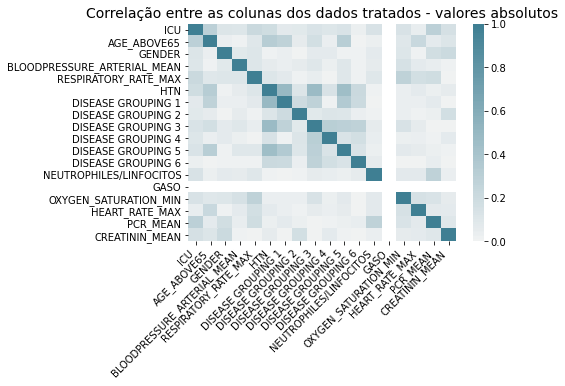

In [ ]:
corr_heatmap(dados_tratados_features)

## Lazy Predict

---
O LazyPredict foi utilizado com o objetivo de avaliar a performance de vários modelos de predição de forma rápida.

Desta forma, a escolha do algorítimo a ser utilizada será mais assertiva.

Neste caso, o modelo LGBMClassifier obteve o melhor resultado, empatado em todos os quesitos com o XGBClassifier mas, teve a execução mais rápida.

---

In [ ]:
gerar_lazypredict(dados_tratados_features)

100%|██████████| 29/29 [00:01<00:00, 21.53it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.73,0.72,0.72,0.72,0.05
XGBClassifier,0.73,0.72,0.72,0.72,0.06
AdaBoostClassifier,0.72,0.71,0.71,0.71,0.17
SVC,0.70,0.70,0.70,0.70,0.02
LogisticRegression,0.70,0.69,0.69,0.69,0.03
ExtraTreesClassifier,0.68,0.68,0.68,0.68,0.16
RandomForestClassifier,0.68,0.67,0.67,0.67,0.19
NuSVC,0.68,0.67,0.67,0.67,0.02
RidgeClassifierCV,0.68,0.67,0.67,0.67,0.02


## LGBMClassifier

---
O Light Gradiente Boosting Machine é um algoritmo baseado em árvores que possui uma grande velocidade de execução de treinos e testes.

Embora tenha sido o algoritmo de escolha, dado o resultado no LazyPredict, o LGBMClassifier não é recomendado para conjuntos de dados pequenos pela  alta capacidade de *overfit*.

---

---
O parâmetro que será considerado como medida de sucesso é o AUC (Area Under the Curve). Este parâmetro resume em um único valor a curva ROC (Receiver Operating Characteristcs), que é uma curva de probabilidade.

Quanto maior o valor AUC, maior é a chance do algoritmo conseguir classificar corretamente os registros.

AUC inicial do LGBMClassifier considerando os parametros default foi de 0.74

---

In [ ]:
modelo = LGBMClassifier()
teste, treino = roda_modelo_cv(modelo, dados_tratados_features, 5, 10)
teste

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7376336803310488

Avaliacao de desempenho variando o parametro num_leaves.

O LGBM Classifier possui um crescimento vertical, enquanto os algoritmos baseado em arvores cresce horizontalmente e, por isso, o parametro num_leaves tem grande importância.

  0%|          | 0/61 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

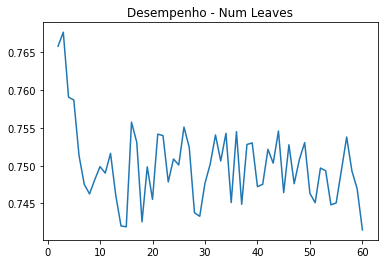

In [ ]:
lgbm_leaves(dados_tratados_features, 0, 61, 1)

Avaliação de desempenho variando o parametro max_depth

  0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

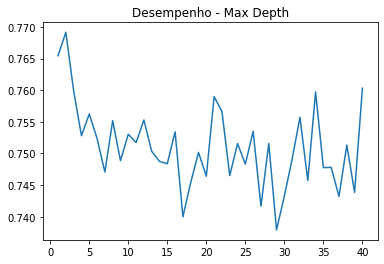

In [ ]:
lgbm_maxdepth(dados_tratados_features, 1, 41, 1)

Avaliação de desempenho variando o parametro estimators.

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

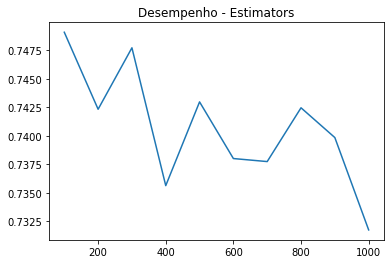

In [ ]:
lgbm_estimators(dados_tratados_features, 100, 1001, 100)

---
Sendo assim, os parametros considerados para ajuste:
- num_leaves: 2
- max_depth: 2
- n_estimators: 100 (default)


Considerando o AUC de aproximadamente 0.72 identificado pelo LazyPredict e o AUC de aproximadamente 0.74 durante a verificação inicial sem parâmetros, ao ajustar os parâmetros supracitados, o algoritmo atingiu o AUC de 0.77

---

In [ ]:
modelo = LGBMClassifier(num_leaves=2, max_depth=2)
teste, treino = roda_modelo_cv(modelo, dados_tratados_features, 5, 10)
teste

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7676886934781672

Como comparação, os mesmos parametros foram utilizados com o conjunto de dados completo, antes da remoção dos campos que não faziam parte das features selecionadas pelo autor do desafio.

O resultado foi levemente superior e o AUC Médio foi de 0.78


In [ ]:
modelo = LGBMClassifier(num_leaves=2, max_depth=2)
teste, treino = roda_modelo_cv(modelo, dados_tratados, 5, 10)
teste

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7814912213349713

# Conclusão
---
Embora o algoritmo de escolha não seja o mais apropriado para conjuntos pequenos de dados, o LGBMClassifier atingiu um AUC de 0.77 de precisão.

Para os próximos passos, talvez valha a pena comparar o resultado do LGBMClassifier com o XGBClassifier, que também teve um bom desempenho de acordo com o LazyPredict.

Também seria interessante o uso de algoritmos com melhores performance com pequenos datasets, tais como SVC ou LogisticRegression.


---

# Fontes
- https://blog.neoprospecta.com/origens-sars-cov-2/
- https://pt.wikipedia.org/wiki/Coronavírus_da_síndrome_respiratória_aguda_grave_2
- https://ourworldindata.org/coronavirus
- https://saude.estadao.com.br/noticias/geral,cidades-de-sp-registram-pelo-menos-88-mortes-de-pacientes-da-covid-na-fila-por-leito
- https://www.correiobraziliense.com.br/brasil/2021/03/4912974-brasileiros-infectados-pela-covid-19-morrem-em-filas-a-espera-de-vagas-uti.html
- https://www.kaggle.com/Sírio-Libanes/covid19/code
- https://towardsdatascience.com/how-to-run-30-machine-learning-models-with-2-lines-of-code-d0f94a537e52
- https://lazypredict.readthedocs.io/en/latest/
- https://lightgbm.readthedocs.io/en/latest/index.html